In [20]:
from pathlib import Path
import os
import sys
path_dcf = str(Path(os.path.abspath('.')).resolve().parent)
sys.path.append(path_dcf)
from config import *
from algorithms.oneshot_dcf import DCF
from utils import *
from algorithms.utils_dilated_tubules import *
import pandas as pd
import tifffile
import matplotlib.pyplot as plt
import cv2
from torch_contour import CleanContours
height = 512

### Choose support image and corresponding contour

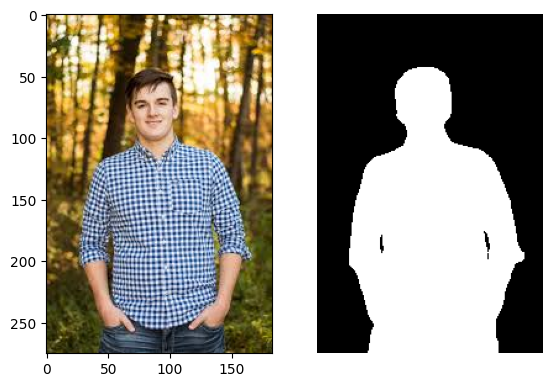

In [21]:
filename_support = "human1.jpg"
img = plt.imread(os.path.join(path_dcf,"images_test", filename_support)).astype(np.uint8)
gt =plt.imread(os.path.join(path_dcf,"images_test", "gt",filename_support.split('.')[-2]+".png")).astype(np.uint8)
f, axarr = plt.subplots(1,2)
plt.axis('off')
axarr[0].imshow(img)
axarr[1].imshow(gt, cmap='gray')
plt.show()

### Instanciate DCF one-shot

In [22]:
dcf = DCF(
    n_epochs=20,
    nb_augment=5,
    learning_rate=100,
    clip=1e-4,
    sigma=1,
    lambda_area=1.,
    exponential_decay=0.999,
    thresh=1e-2,
)

### Fit the one shot DCF on the support image and contour

In [23]:
img_support = cv2.resize(img, (height,height), interpolation = cv2.INTER_AREA).astype(np.uint8)
gt_support = cv2.resize(gt, (height,height), interpolation = cv2.INTER_AREA).astype(np.uint8)
contours = np.squeeze(cv2.findContours(gt,1,3)[0][-1])/height
c = CleanContours()
contour_support = c.interpolate(contours, 100).clip(0, 1)
contour_support = torch.tensor(contour_support)[None, None]
tensor_support = torch.tensor(np.moveaxis(img_support,-1,0)[None])/255

In [24]:
dcf.fit(tensor_support, contour_support)

100%|██████████| 5/5 [00:12<00:00,  2.48s/it]


### Initialize contour and predict on the query

In [25]:
filename_query = "human2.jpg"
img_query = plt.imread(os.path.join(path_dcf,"images_test", filename_support)).astype(np.uint8)
img_query = cv2.resize(img_query, (height,height), interpolation = cv2.INTER_AREA).astype(np.uint8)
tensor_query = torch.tensor(np.moveaxis(img_query,-1,0)[None])/255

In [26]:
contour_init, mask = define_contour_init(
    height, center=[250, 250], axes=[250, 250], angle=0
)
x = contour_init / height

# ### Change the initial contour to set up a number of nobes
nb_nodes = 100
c = CleanContours()
contour_init = c.interpolate(x, nb_nodes).clip(0, 1)
# ### predict
contour_init = torch.tensor(contour_init)[None, None]

In [ ]:
contours, score, tots, energies = dcf.predict(tensor_query,
                                               contour_init)


contour_to_display = (contours[0]*height).astype(int)
new_img = cv2.drawContours((((img_query/np.max(img_query))*255).astype(np.uint8)).copy(),
                        [contour_to_display],
                        0,
                        color = 1,
                        thickness=2)
plt.imshow(new_img)
plt.show()

 25%|██▌       | 5/20 [00:09<00:29,  1.93s/it]